# Kickstarter Success Prediction

This notebook builds a machine learning pipeline to predict whether a Kickstarter campaign will succeed or fail.

## 🎯 Objective:
Classify Kickstarter projects as **successful** or **failed** based on historical features.

## 📊 Dataset:
**Source**: [Kickstarter Projects on Kaggle](https://www.kaggle.com/datasets/kemical/kickstarter-projects)

The dataset contains 300,000+ records of past campaigns, including:
- Launch/deadline dates
- Goal amounts
- Country, currency, and category
- Final state (`successful`, `failed`, etc.)

We use only the `successful` and `failed` rows for binary classification.

This notebook builds a machine learning pipeline to predict whether a Kickstarter campaign will succeed or fail.

## 📦 1. Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

## 📂 2. Load Dataset

In [ ]:
data = pd.read_csv(r'E:\ML_Project\kickstarter-success-prediction\data\ks-projects-201801.csv')
data.head()

## 🔍 3. Initial Inspection

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


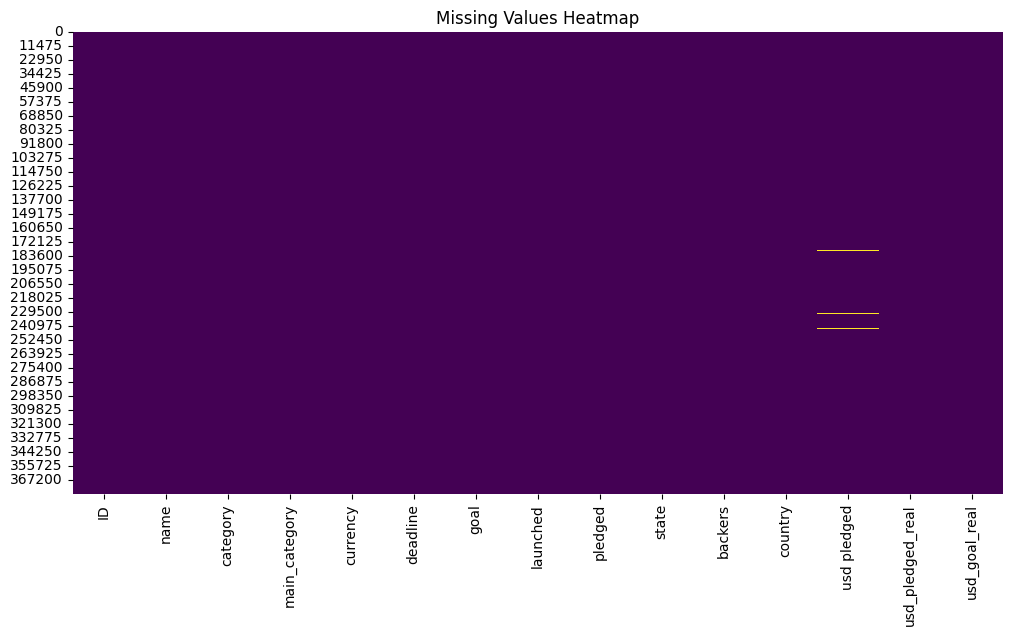

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

## 📉 4. Target Distribution

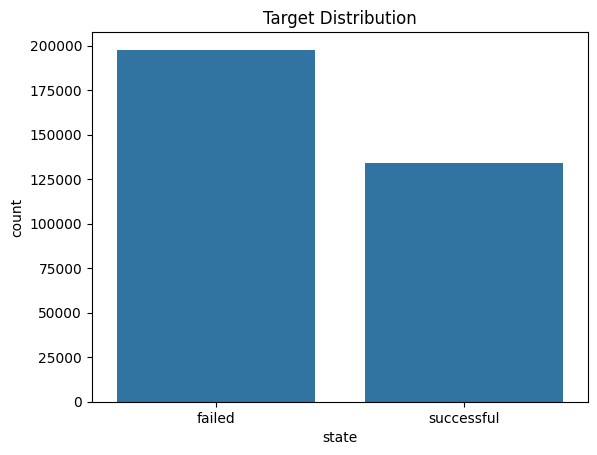

In [9]:
sns.countplot(data=data[data['state'].isin(['failed', 'successful'])], x='state')
plt.title('Target Distribution')
plt.show()

## 🧹 5. Data Cleaning

In [10]:
# Drop unneeded columns
data = data.drop(['ID', 'name'], axis=1)

In [11]:
# Filter only successful and failed
data = data[data['state'].isin(['failed', 'successful'])].reset_index(drop=True)

In [12]:
# Fill missing
data['usd pledged'] = data['usd pledged'].fillna(data['usd pledged'].mean())

In [13]:
# Drop leaky columns
leakage_cols = ['pledged', 'usd pledged', 'usd_pledged_real', 'backers']
data.drop(columns=[col for col in leakage_cols if col in data.columns], inplace=True)

## 🛠️ 6. Feature Engineering

In [14]:
# Convert to datetime
data['deadline'] = pd.to_datetime(data['deadline'], errors='coerce')
data['launched'] = pd.to_datetime(data['launched'], errors='coerce')

In [15]:
# Drop invalid dates
data.dropna(subset=['deadline', 'launched'], inplace=True)

In [16]:
# New features
data['duration_days'] = (data['deadline'] - data['launched']).dt.days
data['launch_month'] = data['launched'].dt.month
data['launch_dow'] = data['launched'].dt.dayofweek
data['launch_weekend'] = data['launch_dow'].isin([5, 6]).astype(int)
data['launch_holiday'] = data['launch_month'].isin([11, 12]).astype(int)

In [17]:
# Log transform goal
data['log_goal'] = np.log1p(data['goal'])
data['goal_per_day'] = data['log_goal'] / data['duration_days'].replace(0, 1)

In [18]:
# Drop old date columns
data.drop(columns=['goal', 'deadline', 'launched'], inplace=True)

In [19]:
# Binning and interaction
data['duration_bins'] = pd.cut(data['duration_days'], bins=[0, 15, 30, 60, 1000], labels=False)
data['goal_bins'] = pd.qcut(data['log_goal'], q=4, labels=False)
data['goal_weekend_interaction'] = data['goal_per_day'] * data['launch_weekend']

## 🔢 7. Prepare Data for Modeling

In [20]:
# Encode target
y = data['state'].map({'failed': 0, 'successful': 1})
X = data.drop('state', axis=1)

In [21]:
# Identify column types
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

## ⚙️ 8. Preprocessing Pipeline

In [22]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [23]:
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [24]:
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

## 🤖 9. Model Pipeline with SMOTE and Random Forest

In [ ]:
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'))
])

## 🧪 10. Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## 🏋️‍♂️ 11. Fit Random Forest Model

In [ ]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['usd_goal_real',
                                                   'duration_days',
                                                   'launch_weekend',
                                                   'launch_holiday', 'log_goal',
                                                   'goal_per_day',
                                                   'duration_bins', 'goal_bins',
                                                   'goal_weekend_interaction']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'main_category',
                                                   'currency', 'country'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## 🔎 12. Evaluate Random Forest

In [ ]:
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

## 📊 13. Confusion Matrix

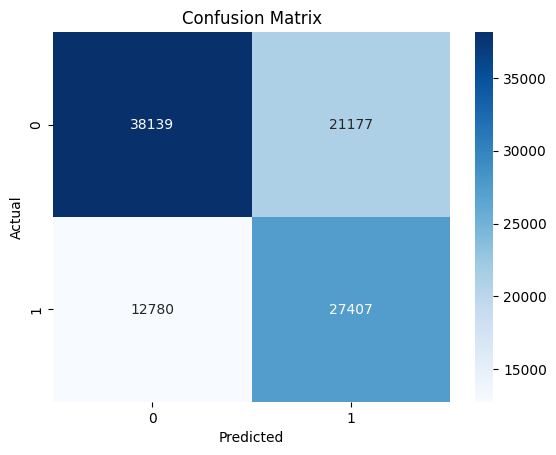

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 📈 14. ROC Curve

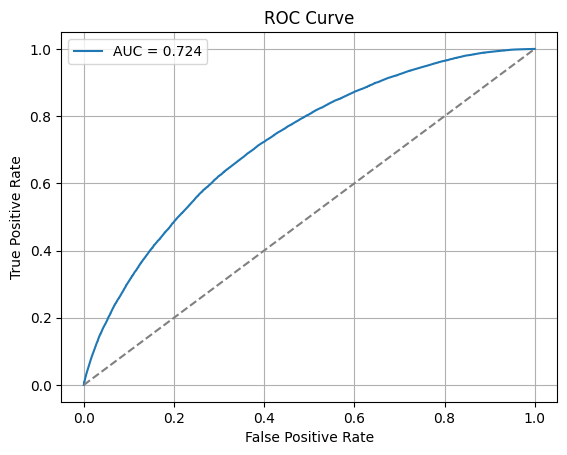

In [ ]:
tpr, fpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()